In [1]:
# Source https://github.com/ml-postech/GM-VAE

# Intro

In [2]:
import torch
from torch import nn
from math import log
from torch.nn import functional as F
import torchvision.transforms as T
import numpy as np

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda')

In [5]:
device

device(type='cuda')

In [6]:
# create false image
image = torch.randint(0, 255, (3, 3, 512, 512), dtype=torch.float32).to(device)

# Encoder

In [7]:
# not from gm-vae, just want to uinderstand it better since every task has different encoder and decoder layers
class Encoder(nn.Module):
    def __init__(self, kernel:int=3, stride:int=1, padding:int=0, device='cpu') -> None:
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            # nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel, stride, padding), # input image will be bx3x512x512, output bx32x508x508
            nn.AvgPool2d(3, 2), # 2x2 avg pooling, TODO: decide if want to use max pooling output bx32x253x253
            nn.ReLU(), # output bx32x253x253
            nn.Conv2d(32, 64, kernel, stride, padding), # input bx32x253x253, output bx64x251x251
            nn.AvgPool2d(3, 2), # 2x2 avg pooling, output bx64x125x125
            nn.ReLU(), # output bx64x125x125
            nn.Conv2d(64, 64, kernel, stride, padding), # input bx64x125x125, output bx64x123x123
            nn.AvgPool2d(3, 2), # 2x2 avg pooling, output bx64x61x61
            nn.ReLU(), # output bx64x61x61
            nn.Flatten(), # output bx64*61*61
        ).to(device)

        self.encoder.apply(self.init_weights)

        self.layer_mean = nn.Linear(64*61*61, 2048).to(device)
        self.layer_logvar = nn.Linear(64*61*61, 2048).to(device)


        """
        Calculating the output size of the encoder
        [(W-F+2P)/S + 1]. [(512-3+0)/1 + 1] = 510 conv1
        [(W-F)/S] + 1]. [(510-3)/2 + 1] = 254 pool1
        [(W-F+2P)/S + 1]. [(253-3+)/1 + 1] = 252 conv2
        [(W-F)/S] + 1]. [(251-3)/2 + 1] = 125 pool2
        [(W-F+2P)/S + 1]. [(125-3+)/1 + 1] = 123 conv3
        [(W-F)/S] + 1]. [(123-3)/2 + 1] = 61 pool3
        """
    def init_weights(self, m):
      if isinstance(m, nn.Linear):
          nn.init.xavier_uniform(m.weight)
          m.bias.data.fill_(0.01)

    def resize(self, x: torch.Tensor) -> torch.Tensor:
        # resize image to 3x512x512
        x = F.interpolate(x, size=(512, 512), mode='bilinear', align_corners=True)
        return x

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        x = self.resize(x)
        x = self.encoder(x)
        mean = self.layer_mean(x)
        logvar = self.layer_logvar(x)

        return x, mean, logvar

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.encode(x)




In [8]:
# encoder = Encoder()

In [9]:
# import numpy as np
# np.argmax(image)

In [10]:
# image.shape

In [11]:
# image[0][:, 0, 0]

In [12]:
# output_image = encoder.encode(image)
# [(W-F+2P)/S + 1]. [(512-3+0)/1 + 1] = 510 conv1
# [(W-F)/S] + 1]. [(510-3)/2 + 1] = 254 pool1
# [(W-F+2P)/S + 1]. [(253-3+)/1 + 1] = 252 conv2
# [(W-F)/S] + 1]. [(251-3)/2 + 1] = 125 pool2
# [(W-F+2P)/S + 1]. [(125-3+0)/1 + 1] = 123 conv3
# [(W-F)/S] + 1]. [(123-3)/2 + 1] = 61 pool3
# [(W-F+2P)/S + 1]. [(61-3+0)/1 + 1] = 59 conv4
# [(W-F)/S] + 1]. [(59-3)/2 + 1] = 29 pool4


In [13]:
# encoder

# Start of autoencoder class

In [14]:
class VAE(nn.Module):
    def __init__(self, device='cpu') -> None:
        super(VAE, self).__init__()
        self.encoder = Encoder().to(device)
        self.decoder = None

    def reparameterize(self, mean: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        # log var = (log var^2) / 2
        # e ^ log var = e^(log var^2 / 2)
        # e ^ log var = e^ (2 * (log var) / 2)
        # e ^ log var = e^ (log var)
        # e ^ log var = var
        # var = var (this is why we use logvar instead of variation, it makes it possible for back propagation to know if a number is negative or positive)

        eps = 0.5
        z = mean + eps * torch.exp(logvar)
        return z

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z), mean, logvar

In [15]:
# vae = VAE(device).to(device)

In [16]:
# x, mean, logvar = vae.encoder.encode(image)

In [17]:
# x

In [18]:
# print(f"x shape: {x.shape}, mean shape: {mean.shape}, logvar shape: {logvar.shape}")
# print(f"type of x: {type(x)}, type of mean: {type(mean)}, type of logvar: {type(logvar)}")

In [19]:
# z = vae.reparameterize(mean, logvar)

In [20]:
# print(f"z shape: {z.shape}")

In [21]:
# z

# Decoder

In [22]:
class Decoder(nn.Module):
    def __init__(self, kernel:int=3, stride:int=1, padding:int=0, device='cpu') -> None:
        super(Decoder, self).__init__()
        self.kernel = kernel
        self.stride = stride
        self.padding = padding
        self.device = device

        self.decoder = nn.Sequential(
            nn.Linear(2048, 64*61*61),
            nn.Unflatten(dim=1, unflattened_size=(64, 61, 61)),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, 2, self.padding),
            nn.ConvTranspose2d(64, 64, self.kernel, self.stride, self.padding),

            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, 2, self.padding),
            nn.ConvTranspose2d(64, 32, self.kernel, self.stride, self.padding),

            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 2, 2, self.padding),
            nn.ConvTranspose2d(32, 32, 5, 1, self.padding),
            nn.ConvTranspose2d(32, 3, self.kernel, self.stride, self.padding),

            nn.Sigmoid()
        ).to(device)


    def decode(self, x: torch.Tensor) -> torch.Tensor:
        x = self.decoder(x)
        return x

    def forward(self, r_samples: torch.Tensor) -> torch.Tensor:
        return self.decode(r_samples)


# VAE completed

In [23]:
class VAE(nn.Module):
    def __init__(self, kernel:int=3, stride:int=1, padding:int=0, device='cpu') -> None:
        super(VAE, self).__init__()
        self.kernel = kernel
        self.stride = stride
        self.padding = padding
        self.device = device

        self.encoder = Encoder().to(self.device)
        self.decoder = Decoder().to(self.device)

    def reparameterize(self, mean: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        # log var = (log var^2) / 2
        # e ^ log var = e^(log var^2 / 2)
        # e ^ log var = e^ (2 * (log var) / 2)
        # e ^ log var = e^ (log var)
        # e ^ log var = var
        # var = var (this is why we use logvar instead of variation, it makes it possible for back propagation to know if a number is negative or positive)

        eps = 0.5
        z = mean + eps * torch.exp(logvar)
        return z

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded, mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        decoded = self.decoder(z)

        return encoded, mean, logvar, decoded

# Training

In [24]:
!pip install patool

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import patoolib

In [27]:
!pwd

/content


In [28]:
patoolib.extract_archive('/content/drive/MyDrive/dataset/data_train_test.zip')

INFO patool: Extracting /content/drive/MyDrive/dataset/data_train_test.zip ...
INFO:patool:Extracting /content/drive/MyDrive/dataset/data_train_test.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_j6xitgb7 -- /content/drive/MyDrive/dataset/data_train_test.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_j6xitgb7 -- /content/drive/MyDrive/dataset/data_train_test.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/drive/MyDrive/dataset/data_train_test.zip extracted to `data_train_test13' (local file exists).
INFO:patool:... /content/drive/MyDrive/dataset/data_train_test.zip extracted to `data_train_test13' (local file exists).


'data_train_test13'

In [29]:
!ls

cifar-10-batches-py	data_train_test10  data_train_test3  data_train_test8	  Unpack_smvm76rh
cifar-10-python.tar.gz	data_train_test11  data_train_test4  data_train_test9	  wandb
data			data_train_test12  data_train_test5  data_train_test.zip
data_train_test		data_train_test13  data_train_test6  drive
data_train_test1	data_train_test2   data_train_test7  sample_data


In [30]:
!unzip /drive/content/My Drive/data_train_test.zip -d /drive/content/My Drive/data_train_test

unzip:  cannot find or open /drive/content/My, /drive/content/My.zip or /drive/content/My.ZIP.


In [31]:
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [32]:
import pathlib as pl
from glob import glob

In [33]:
from PIL import Image

In [34]:
class PNDBDataset(Dataset):
    """P-NDB-Dataset"""

    def __init__(self, folder_path, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.path = folder_path
        self.classes_to_idx = {
            "carcinoma": 0,
            "no_dysplasia": 1,
            "with_dysplasia": 2
        }

        self.img_transform = T.Compose([T.PILToTensor()])
        self.transform = transform
        self._organize_image()


    def _load_image(self, path):
        im = Image.open(path)
        im = self.img_transform(im)
        return im

    def _organize_image(self):
        carcinoma_images_path = pl.Path(f"{self.path}/carcinoma")
        no_dysplasia_images_path = pl.Path(f"{self.path}/no_dysplasia")
        dysplasia_images_path = pl.Path(f"{self.path}/dysplasia")

        carcinoma_images = glob(f'{str(carcinoma_images_path)}/*.png')
        no_dysplasia_images = glob(f'{str(no_dysplasia_images_path)}/*.png')
        dysplasia_images = glob(f'{str(dysplasia_images_path)}/*.png')

        carcinoma_image_list = [self._load_image(path) for path in carcinoma_images]
        no_dysplasia_image_list = [self._load_image(path) for path in no_dysplasia_images]
        dysplasia_image_list = [self._load_image(path) for path in dysplasia_images]

        carcinoma_targets = torch.zeros(len(carcinoma_images))
        no_dysplasia_targets = torch.ones(len(no_dysplasia_images))
        dysplasia_targets = torch.ones(len(dysplasia_images)) * 2

        images_list = []
        images_list.extend(carcinoma_image_list)
        images_list.extend(no_dysplasia_image_list)
        images_list.extend(dysplasia_image_list)

        targets_list = []
        targets_list.extend(carcinoma_targets)
        targets_list.extend(no_dysplasia_targets)
        targets_list.extend(dysplasia_targets)

        self.data = torch.tensor(np.array(images_list)) / 1.
        self.target = torch.tensor(targets_list)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        target = self.target[idx]

        if self.transform:
            image = self.transform(image)

        return image, target

In [35]:
train_dataset = PNDBDataset("/content/data/train")
test_dataset = PNDBDataset("/content/data/test")

In [36]:
learning_rate = 1e-3
batch_size = 64
epochs = 1

In [37]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [38]:
len(train_dataloader)

26

In [39]:
len(train_dataset)

1649

In [40]:
vae = VAE(device=device)

In [41]:
optimizer = torch.optim.SGD(vae.parameters(), lr=learning_rate)

In [42]:
loss_fn = F.mse_loss

In [43]:
len(train_dataloader)

26

In [44]:
train_dataloader

In [45]:
!pip install wandb
import wandb

In [46]:
wandb.login()

wandb: Currently logged in as: beatriz-maia. Use `wandb login --relogin` to force relogin


True

In [47]:
wandb.init(
        project="tcc",
        config={
            "epochs": epochs,
            "batch_size": batch_size,
            "lr": learning_rate,
            "optimizer": "SGD"
            })

In [48]:
len(train_dataloader)

26

In [49]:
train_dataset[0]

(tensor([[[193., 191., 188.,  ..., 196., 194., 193.],
          [195., 191., 189.,  ..., 193., 190., 191.],
          [188., 186., 188.,  ..., 195., 191., 194.],
          ...,
          [210., 208., 209.,  ..., 200., 199., 196.],
          [210., 212., 211.,  ..., 199., 200., 199.],
          [209., 215., 215.,  ..., 199., 198., 198.]],
 
         [[130., 128., 125.,  ..., 138., 135., 136.],
          [131., 131., 129.,  ..., 132., 131., 132.],
          [129., 128., 130.,  ..., 132., 131., 131.],
          ...,
          [158., 158., 157.,  ..., 140., 138., 141.],
          [158., 157., 154.,  ..., 141., 142., 142.],
          [157., 157., 154.,  ..., 142., 140., 140.]],
 
         [[187., 185., 182.,  ..., 189., 191., 191.],
          [192., 191., 189.,  ..., 189., 187., 186.],
          [185., 186., 189.,  ..., 185., 183., 184.],
          ...,
          [197., 196., 196.,  ..., 194., 195., 199.],
          [196., 197., 195.,  ..., 192., 193., 197.],
          [195., 197., 196.,  .

In [50]:
vae.train()
total_loss = []
n_steps_per_epoch = len(train_dataloader)
for epoch in range(epochs):
    epochs_loss = []
    for i, data in enumerate(train_dataloader):
        # Compute prediction and loss
        X, y = data
        X, y = X.to(device), y.to(device)
        encoded, mean, logvar, decoded = vae(X)

        print(decoded * 255)
        kl = - 0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar), axis=1)
        kl_mean = kl.mean()
        batchsize = X.shape[0]

        pixelwise = loss_fn(decoded * 255, X, reduction='none')
        pixelwise = pixelwise.sum(axis=1)
        pixelwise_mean = pixelwise.mean()


        loss = 1 * pixelwise_mean + kl_mean

        if not i % 10:
          print("pixelwise", pixelwise_mean)
          print("kl", kl_mean)
          print("loss", loss)
          print()

        optimizer.zero_grad()

        # Backpropagation
        loss.backward()
        optimizer.step()

        epochs_loss.append(loss.cpu().detach().numpy())
        metrics = {"train/train_loss": loss,
                    "train/epoch": (i + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
                    "train/kl_div": kl_mean,
                    "train/mse_loss": pixelwise_mean,
                    "train/epoch": epoch + 1}

        wandb.log(metrics)


tensor([[[[2.4815e+02, 2.5500e+02, 1.4525e+01,  ..., 2.5500e+02,
           2.5439e+02, 4.5514e+01],
          [2.4231e-04, 1.4538e-07, 2.5500e+02,  ..., 1.6262e-06,
           3.0464e+01, 9.7555e+01],
          [2.5500e+02, 2.5500e+02, 1.8708e-03,  ..., 2.4035e+02,
           1.2550e-08, 1.7440e+01],
          ...,
          [2.5500e+02, 7.1114e-04, 1.4588e-24,  ..., 2.5500e+02,
           2.5500e+02, 1.7855e+01],
          [5.1335e-02, 2.1614e-01, 9.1866e-03,  ..., 2.5492e+02,
           2.5481e+02, 2.5496e+02],
          [5.0398e+00, 1.5453e-01, 1.0673e-01,  ..., 2.5385e+02,
           9.6068e-02, 4.8286e+01]],

         [[2.5276e+02, 1.4688e-01, 6.1293e+00,  ..., 1.4303e+02,
           1.4557e-02, 1.1772e+01],
          [2.2420e+02, 1.8143e+00, 1.0467e+00,  ..., 9.5693e+00,
           1.2310e-01, 2.5356e+02],
          [1.0033e+02, 2.3921e+01, 2.4450e-06,  ..., 2.5500e+02,
           7.2539e-05, 1.2054e+02],
          ...,
          [2.5423e+02, 2.5446e+02, 2.5205e+02,  ..., 2.5500

In [51]:
wandb.finish()

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/kl_div,▁
train/mse_loss,▁
train/train_loss,▁
train/epoch,1
train/kl_div,nan
train/mse_loss,nan
train/train_loss,nan


In [52]:
vae.eval()

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): AvgPool2d(kernel_size=3, stride=2, padding=0)
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): AvgPool2d(kernel_size=3, stride=2, padding=0)
      (5): ReLU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (7): AvgPool2d(kernel_size=3, stride=2, padding=0)
      (8): ReLU()
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (layer_mean): Linear(in_features=238144, out_features=2048, bias=True)
    (layer_logvar): Linear(in_features=238144, out_features=2048, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2048, out_features=238144, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(64, 61, 61))
      (2): ReLU()
      (3): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
      (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

In [53]:
x, y = next(iter(test_dataloader))

In [54]:
test_dataset[0][0].shape

torch.Size([3, 512, 512])

In [55]:
import matplotlib.pyplot as plt

<ipython-input-56-341e55afe081>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(test_dataset[0][0].type(torch.uint8).T)


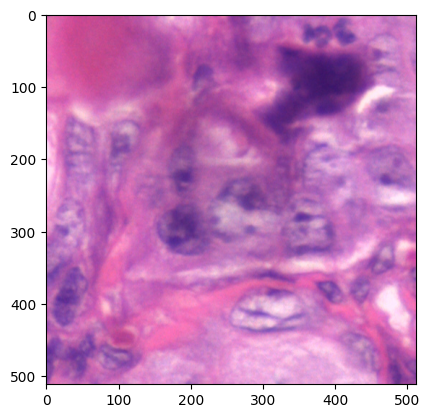

In [56]:
plt.imshow(test_dataset[0][0].type(torch.uint8).T)
plt.show()

In [57]:
train_dataset.classes_to_idx

{'carcinoma': 0, 'no_dysplasia': 1, 'with_dysplasia': 2}

In [58]:
test_dataset[0][0].unsqueeze(0).type(torch.uint8)

tensor([[[[149, 161, 176,  ..., 150, 154, 161],
          [145, 158, 176,  ..., 153, 159, 166],
          [145, 157, 182,  ..., 151, 158, 167],
          ...,
          [221, 222, 220,  ..., 155, 158, 164],
          [221, 216, 218,  ..., 161, 166, 166],
          [214, 216, 213,  ..., 158, 159, 158]],

         [[ 70,  82,  92,  ...,  75,  80,  85],
          [ 71,  83,  92,  ...,  79,  82,  85],
          [ 69,  79,  91,  ...,  85,  87,  89],
          ...,
          [143, 141, 140,  ...,  78,  77,  77],
          [142, 141, 140,  ...,  77,  78,  81],
          [143, 145, 142,  ...,  80,  82,  86]],

         [[159, 165, 169,  ..., 166, 169, 173],
          [160, 166, 169,  ..., 174, 178, 177],
          [159, 163, 170,  ..., 175, 179, 175],
          ...,
          [201, 208, 209,  ..., 156, 156, 156],
          [199, 198, 202,  ..., 162, 162, 162],
          [199, 203, 200,  ..., 166, 164, 162]]]], dtype=torch.uint8)

In [59]:
x_output = vae(test_dataset[0][0].unsqueeze(0).to(device))

In [60]:
x_output

(tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           ...,
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan]],
 
          [[nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           ...,
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan]],
 
          [[nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,

In [61]:
decoded_image = x_output[3].cpu().detach()[0]

In [62]:
decoded_image = decoded_image.type(torch.uint8)

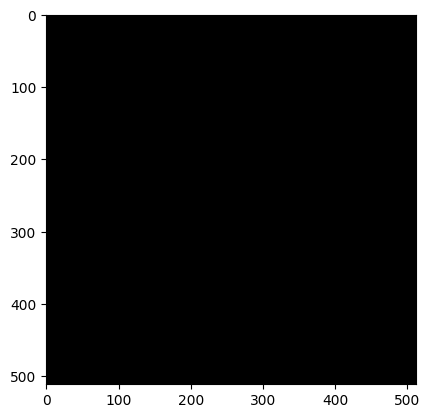

In [63]:
imgplot = plt.imshow(decoded_image.T)
plt.show()